###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2017 L.A. Barba, N.C. Clementi

# Catch things in motion

This module of the _Engineering Computations_ course is our launching pad to investigate _change_, _motion_, _dynamics_, using computational thinking, Python, and Jupyter.

The foundation of physics and engineering is the subject of **mechanics**: how things move around, when pushed around. Or pulled… in the beginning of the history of mechanics, Galileo and Newton seeked to understand how and why objects fall under the pull of gravity.

This first lesson will explore motion by analyzing images and video, to learn about velocity and acceleration.

## Acceleration of a falling ball

Let's start at the beginning. Suppose you want to use video capture of a falling ball to _compute_ the acceleration of gravity. Could you do it? With Python, of course you can!

Here is a neat video we found online, produced over at MIT several years ago [1]. It shows a ball being dropped in front of a metered panel, while lit by a stroboscopic light. Watch the video!

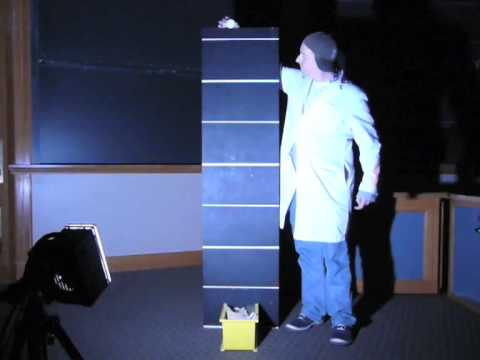

In [1]:
from IPython.display import YouTubeVideo
vid = YouTubeVideo("xQ4znShlK5A")
display(vid)

We learn from the video that the marks on the panel are every $0.25\rm{m}$, and on the [website](http://techtv.mit.edu/collections/physicsdemos/videos/831-strobe-of-a-falling-ball) they say that the strobe light flashes at about 15 Hz (that's 15 times per second). The final [image on Flickr](https://www.flickr.com/photos/physicsdemos/3174207211), however, notes that the strobe fired 16.8 times per second. So we have some uncertainty already!

Luckily, the MIT team obtained one frame with the ball visible at several positions as it falls. This, thanks to the strobe light and a long-enough exposure of that frame. What we'd like to do is use that frame to capture the ball positions digitally, and then obtain the velocity and acceleration from the distance over time. 

You can find several toolkits for handling images and video with Python; we'll start with a simple one called [`imageio`](https://imageio.github.io). Import this library like any other, and let's load `numpy` and `pyplot` while we're at it.


In [2]:
import imageio
import numpy
from matplotlib import pyplot

### Read the video

With the `get_reader()` method of `imageio`, you can read a video from its source into a _Reader_ object. You don't need to worry too much about the technicalities here—we'll walk you through it all—but check the type, the length (for a video, that's number of frames), and notice you can get info, like the frames-per-second, using `get_meta_data()`.

In [3]:
reader = imageio.get_reader('http://techtv.mit.edu/videos/831-strobe-of-a-falling-ball/download.mp4')

In [4]:
type(reader)

imageio.plugins.ffmpeg.FfmpegFormat.Reader

In [5]:
len(reader)

1235

In [6]:
fps = reader.get_meta_data()['fps']
print(fps)

30.0


##### Note:

You may get this error after calling `get_reader()`:

NeedDownloadError: Need ffmpeg exe. You can obtain it with either:
  - install using conda: `conda install ffmpeg -c conda-forge`
  - download by calling: `imageio.plugins.ffmpeg.download()`

If you do, follow the tips to install the needed `ffmpeg` tool.

### Show a video frame in an interactive figure

With `imageio`, you can grab one frame of the video, and then use `pyplot` to show it as an image. But we want to interact with the image, somehow.

So far in this course, we have used the command `%matplotlib inline` to get our plots rendered _inline_ in a Jupyter notebook. There is an alternative command that gives you some interactivity on the figures: `%matplotlib notebook`. Execute this now, and you'll see what it does below, when you show the image in a new figure.

Let's also set some font parameters for our plots in this notebook.

In [7]:
%matplotlib notebook

#Import rcParams to set font styles
from matplotlib import rcParams

#Set font style and size 
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

Now we can use the `get_data()` method on the `imageio` _Reader_ object, to grab one of the video frames, passing the frame number. Below, we use it to grab frame number 1100, and then print the `shape` attribute to see that it's an "array-like" object with three dimensions: they are the pixel numbers in the horizontal and vertical directions, and the number of colors (3 colors in RGB format). Check the type to see that it's an `imageio` _Image_ object.

In [8]:
image = reader.get_data(1100)
image.shape

(480, 640, 3)

In [9]:
type(image)

imageio.core.util.Image

Naturally, `imageio` plays well with `pyplot`. You can use [`pyplot.imshow()`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.imshow.html) to show the image in a figure. We chose to show frame 1100 after playing around a bit and finding that it gives a good view of the long-exposure image of the falling ball.

##### Explore:

Check out the neat interactive options that we get with `%matplotlib notebook`. Then go back and change the frame number above, and show it below. Notice that you can see the $(x,y)$ coordinates of your cursor tip while you hover on the image with the mouse.

<IPython.core.display.Javascript object>


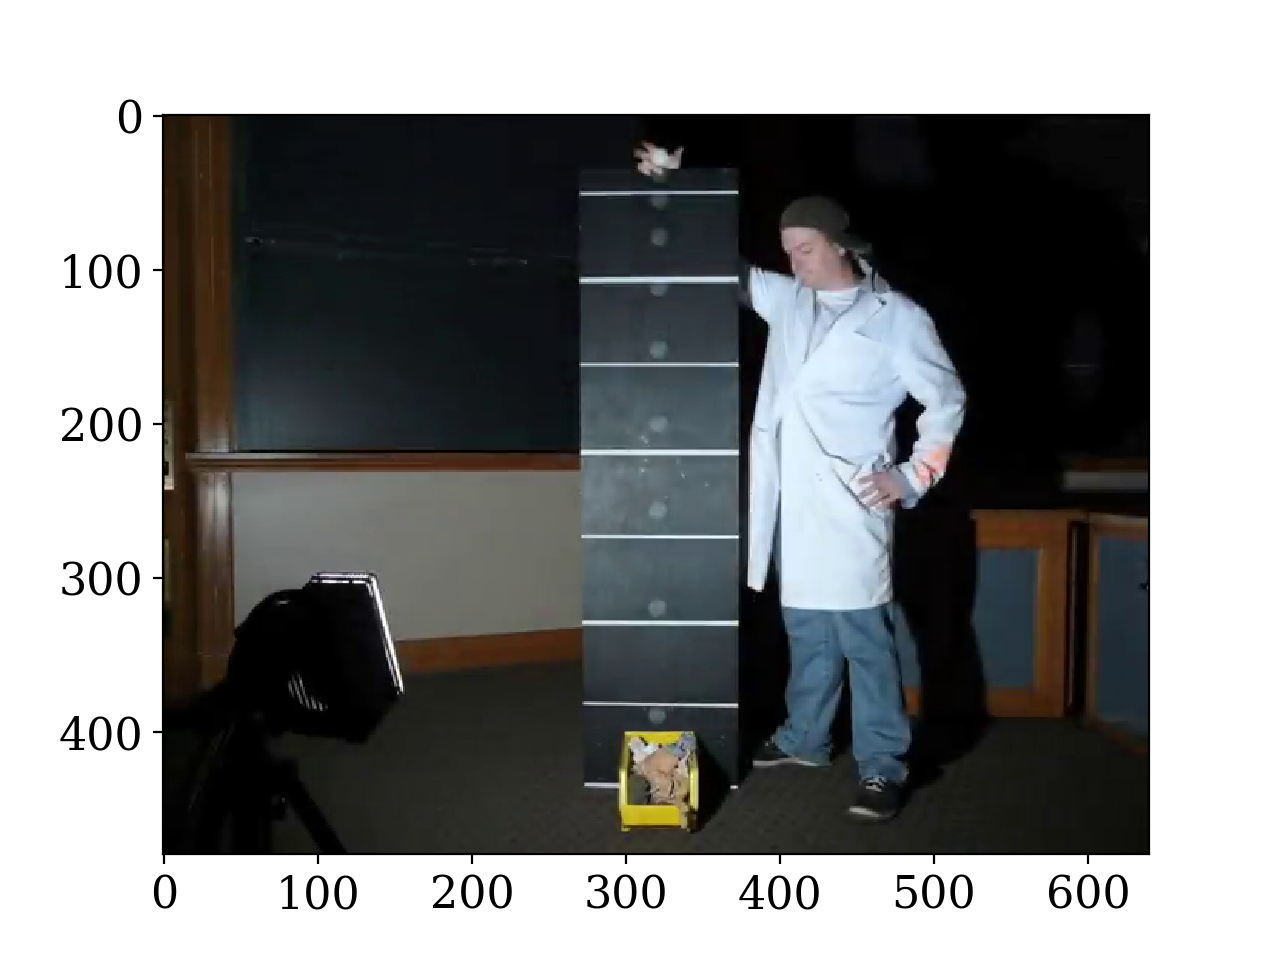

In [10]:
pyplot.imshow(image, interpolation='nearest');

### Capture mouse clicks on the frame

Okay! Here is where things get really interesting. Matplotlib has the ability to create [event connections](https://matplotlib.org/devdocs/users/event_handling.html?highlight=mpl_connect), that is, connect the figure canvas to user-interface events on it, like mouse clicks. 

To use this ability, you write a function with the events you want to capture, and then connect this function to the Matplotlib "event manager" using [`mpl_connect()`](https://matplotlib.org/devdocs/api/backend_bases_api.html#matplotlib.backend_bases.FigureCanvasBase.mpl_connect). In this case, we connect the `'button_press_event'` to the function named `onclick()`, which captures the $(x,y)$ coordinates of the mouse click on the figure. Magic!

<IPython.core.display.Javascript object>


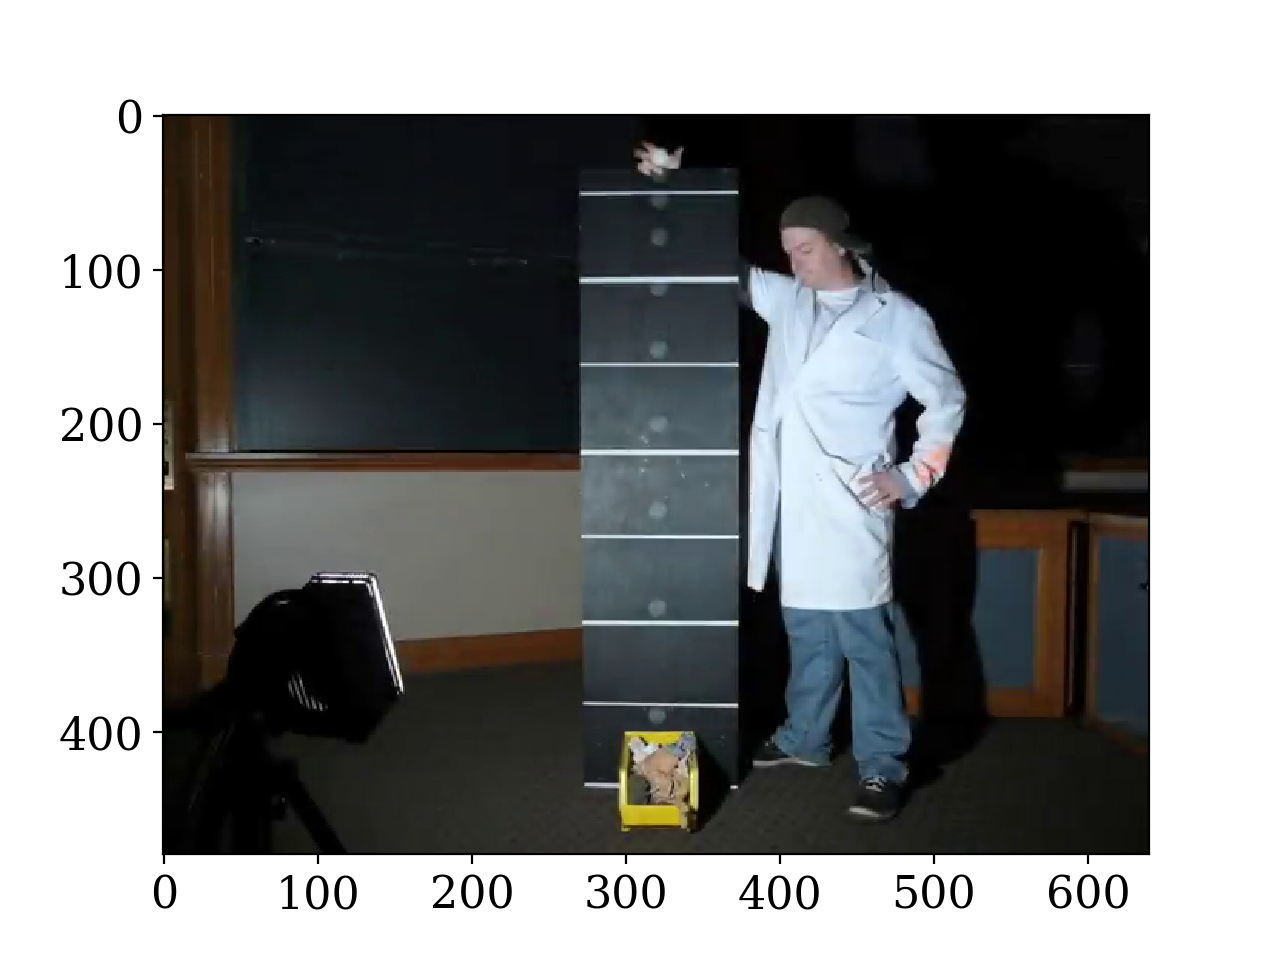

In [11]:
fig = pyplot.figure()

pyplot.imshow(image, interpolation='nearest')

coords = []
def onclick(event):
    '''Capture the x,y coordinates of a mouse click on the image'''
    ix, iy = event.xdata, event.ydata
    coords.append([ix, iy]) 

connectId = fig.canvas.mpl_connect('button_press_event', onclick)


Notice that in the code cell above, we created an empty list named `coords`, and inside the `onclick()` function, we are appending to it the $(x,y)$ coordinates of each mouse click on the figure. After executing the cell above, you have a connection to the figure, via the user interface: try clicking with your mouse on the endpoints of the white lines of the metered panel (click on the edge of the panel to get approximately equal $x$ coordinates), then print the contents of the `coords` list below.

In [12]:
coords

[[270.77840909090912, 53.306818181818073],
 [270.77840909090912, 107.85227272727263],
 [272.07711038961043, 163.6964285714285],
 [272.07711038961043, 219.54058441558436],
 [272.07711038961043, 274.08603896103892],
 [272.07711038961043, 328.63149350649348],
 [273.37581168831173, 383.17694805194799],
 [274.67451298701303, 435.125]]

The $x$ coordinates are pretty close, but there is some variation due to our shaky hand (or bad eyesight), and perhaps because the metered panel is not perfectly vertical. We can cast the `coords` list to a NumPy array, then grab all the first elements of the coordinate pairs, then get the standard deviation as an indication of our error in the mouse-click captures.

In [13]:
numpy.array(coords)[:,0]

array([ 270.77840909,  270.77840909,  272.07711039,  272.07711039,
        272.07711039,  272.07711039,  273.37581169,  274.67451299])

In [14]:
numpy.array(coords)[:,0].std()

1.2039283258272222

Depending how shaky _your_ hand was, you may get a different value, but we got a standard deviation of about one pixel. Pretty good!

Now, let's grab all the second elements of the coordinate pairs, corresponding to the $y$ coordinates, i.e., the vertical positions of the white lines on the video frame.

In [15]:
y_lines = numpy.array(coords)[:,1]
y_lines

array([  53.30681818,  107.85227273,  163.69642857,  219.54058442,
        274.08603896,  328.63149351,  383.17694805,  435.125     ])

Looking ahead, what we'll do is repeat the process of capturing mouse clicks on the image, but clicking on the ball positions. Then, we will want to have the vertical positions converted to physical length (in meters), from the pixel numbers on the image.

You can get the scaling from pixels to meters via the distance between two white lines on the metered panel, which we know is $0.25\rm{m}$. 

Let's get the average vertical distance between two while lines, which we can calculate as:

\begin{equation}
\overline{\Delta y} = \sum_{i=0}^N \frac{y_{i+1}-y_i}{N-1}
\end{equation}

In [16]:
gap_lines = y_lines[1:] - y_lines[0:-1]
gap_lines.mean()

54.545454545454561

##### Discuss with your neighbor

* Why did we slice the `y_lines` array like that? If you can't explain it, write out the first few terms of the sum above and think!

### Compute the acceleration of gravity

We're making good progress! You'll repeat the process of showing the image on an interactive figure, and capturing the mouse clicks on the figure canvas: but this time, you'll click on the ball positions. 

Using the vertical displacements of the ball, $\Delta y_i$, and the known time between two flashes of the strobe light, $1/16.8\rm{s}$, you can get the velocity and acceleration of the ball! But first, to convert the vertical displacements to meters, you'll multiply by $0.25\rm{m}$ and divide by `gap_lines.mean()`.

Before clicking on the ball positions, you may want to inspect the high-resolution final [photograph on Flickr](https://www.flickr.com/photos/physicsdemos/3174207211)—notice that the first faint image of the falling ball is just "touching" the ring finger of Bill's hand. We decided _not_ to use that photograph in our lesson because the Flickr post says _"All rights reserved"_, while the video says specifically that it is licensed under a Creative Commons license. In other words, MIT has granted permission to use the video, but _not_ the photograph. _Sigh_.

OK. Go for it: capture the clicks on the ball!

<IPython.core.display.Javascript object>


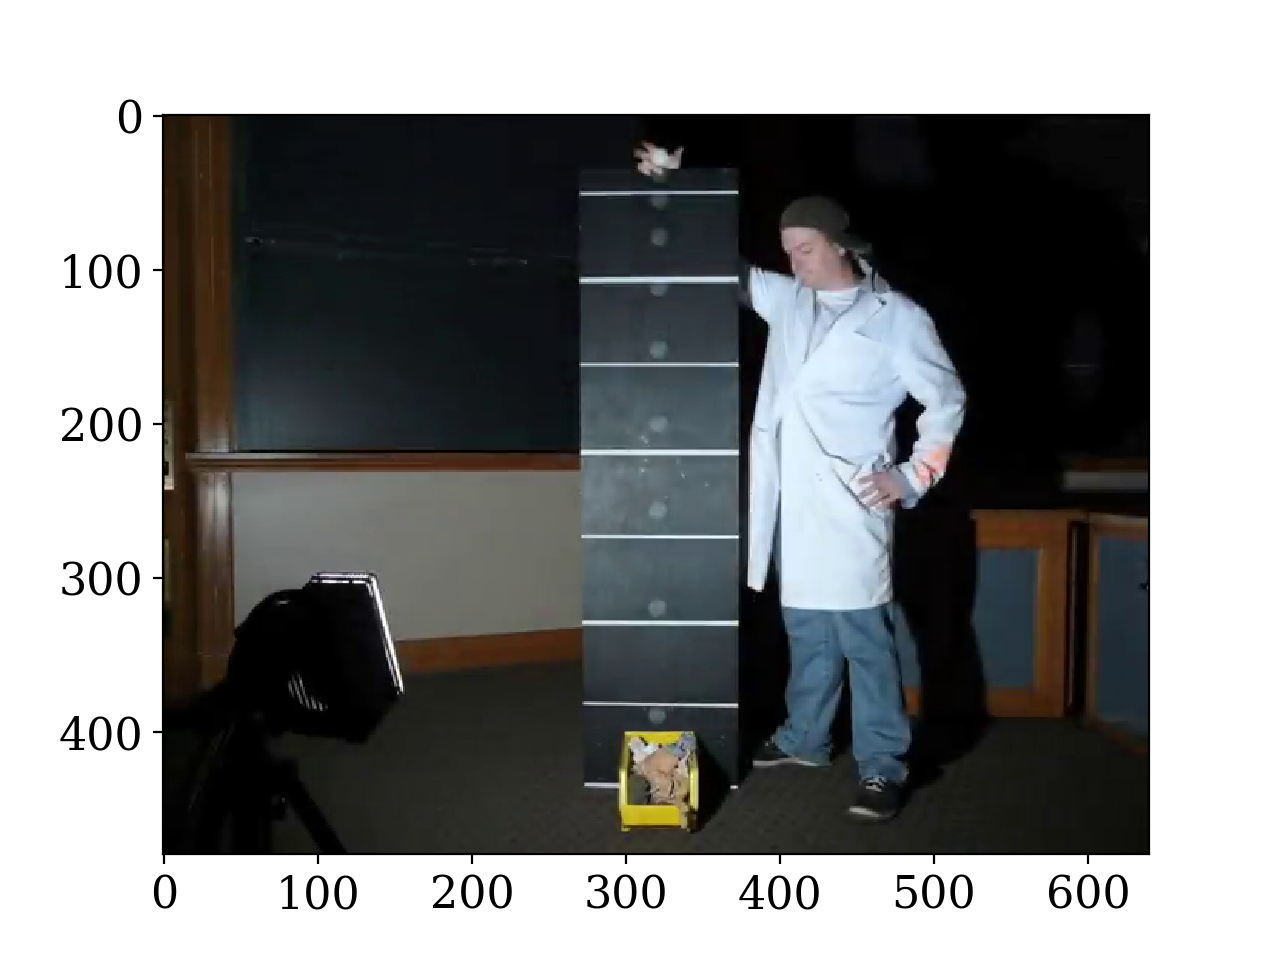

In [17]:
fig = pyplot.figure()

pyplot.imshow(image, interpolation='nearest')

coords = []
def onclick(event):
    '''Capture the x,y coordinates of a mouse click on the image'''
    ix, iy = event.xdata, event.ydata
    coords.append([ix, iy]) 

connectId = fig.canvas.mpl_connect('button_press_event', onclick)

In [18]:
coords

[[321.42775974025972, 38.249999999999886],
 [321.42775974025972, 55.13311688311677],
 [321.42775974025972, 81.107142857142776],
 [321.42775974025972, 112.27597402597394],
 [321.42775974025972, 152.53571428571422],
 [321.42775974025972, 203.18506493506487],
 [320.12905844155841, 257.73051948051943],
 [320.12905844155841, 321.36688311688306],
 [320.12905844155841, 390.1980519480519]]

We'll scale the vertical displacements of the falling ball as explained above (to get distance in meters), then use the known time between flashes of the strobe light, $1/16.8\rm{s}$, to compute estimates of the velocity and acceleration of the ball at every captured instant, using:

\begin{equation}
v_i = \frac{y_{i+1}-y_i}{\Delta t}, \qquad a_i = \frac{v_{i+1}-v_i}{\Delta t}
\end{equation}


In [19]:
y_coords = numpy.array(coords)[:,1]
delta_y = (y_coords[1:] - y_coords[:-1]) *0.25 / gap_lines.mean()

In [20]:
v = delta_y * 16.8
v

array([ 1.3,  2. ,  2.4,  3.1,  3.9,  4.2,  4.9,  5.3])

In [21]:
a = (v[1:] - v[:-1]) *16.8
a

array([ 11.76,   6.72,  11.76,  13.44,   5.04,  11.76,   6.72])

In [22]:
a[1:].mean()

9.2399999999999913

Yikes! That's some wide variation on the acceleration estimates. Our average measurement for the acceleration of gravity is not great, but it's not far off… In case you don't remember, the actual value is $9.8\rm{m/s}^2$.

## Projectile motion

Now, we'll study projectile motion, using a video of a ball "fired" horizontally, like a projectile. Here's a neat video we found online, produced by the folks over at [Flipping Physics](http://www.flippingphysics.com) [2].

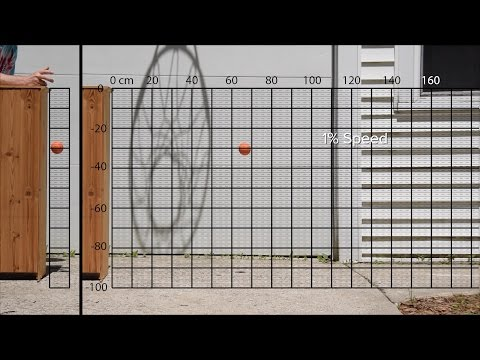

In [23]:
from IPython.display import YouTubeVideo
vid = YouTubeVideo("Y4jgJK35Gf0")
display(vid)

We used Twitter to communicate with the author of the video and ask permission to use it in this lesson. A big _Thank You_ to Jon Thomas-Palmer for letting us use it!

In [24]:
%%html
<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">You have my permission to use the video. Please provide attribution to me. I’d enjoy seeing what you do with it too!</p>&mdash; Jon Thomas-Palmer (@FlippingPhysics) <a href="https://twitter.com/FlippingPhysics/status/926785273538666497?ref_src=twsrc%5Etfw">November 4, 2017</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

### Capture mouse clicks on many frames with a widget

We'd like to capture the coordinates of mouse clicks on a _sequence_ of images, so that we may have the positions of the moving ball caught on video. We know how to capture the coordinates of mouse clicks, so the next challenge is to get consecutive frames of the video displayed for us, to click on the ball position each time. 

Widgets to the rescue! There are currently [10 different widget types](http://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html) included in the `ipywidgets` library. The `BoundedIntText()` widget shows a text box with an integer value that can be stepped from a minimum to a maximum value by clicking up/down arrows. Stepping through frames with this widget, and clicking on the ball position each time, gets us what we want.

Digitizing the ball positions in this way is a bit tedious. But this could be a realistic scenario: you captured video of a moving object, and you need to get position data from the video frames. Unless you have some fancy motion-capture equipment, this will do the trick.

Let's load the Jupyter widgets:

In [25]:
from ipywidgets import widgets

Download the video, previously converted to .mp4 format to be read by `imageio`, and then load it to an `imageio` _Reader_. Notice that it has 3531 frames, and they are 720x1280 pixels in size. 

Below, we're showing frame number 52, which we found to be the start of the portion shown at 50% speed. Go ahead and use that frame to capture mouse clicks on the intersection of several $10\rm{cm}$ lines with one vertical, so you can calculate the scaling from pixels to physical distance.

In [26]:
from urllib.request import urlretrieve
URL = 'http://go.gwu.edu/engcomp3vid1?accessType=DOWNLOAD'
urlretrieve(URL, 'Projectile_Motion.mp4')

('Projectile_Motion.mp4', <http.client.HTTPMessage at 0x116a211d0>)

In [27]:
reader = imageio.get_reader('Projectile_Motion.mp4')

In [28]:
len(reader)

3531

In [29]:
image = reader.get_data(52)
image.shape

(720, 1280, 3)

<IPython.core.display.Javascript object>


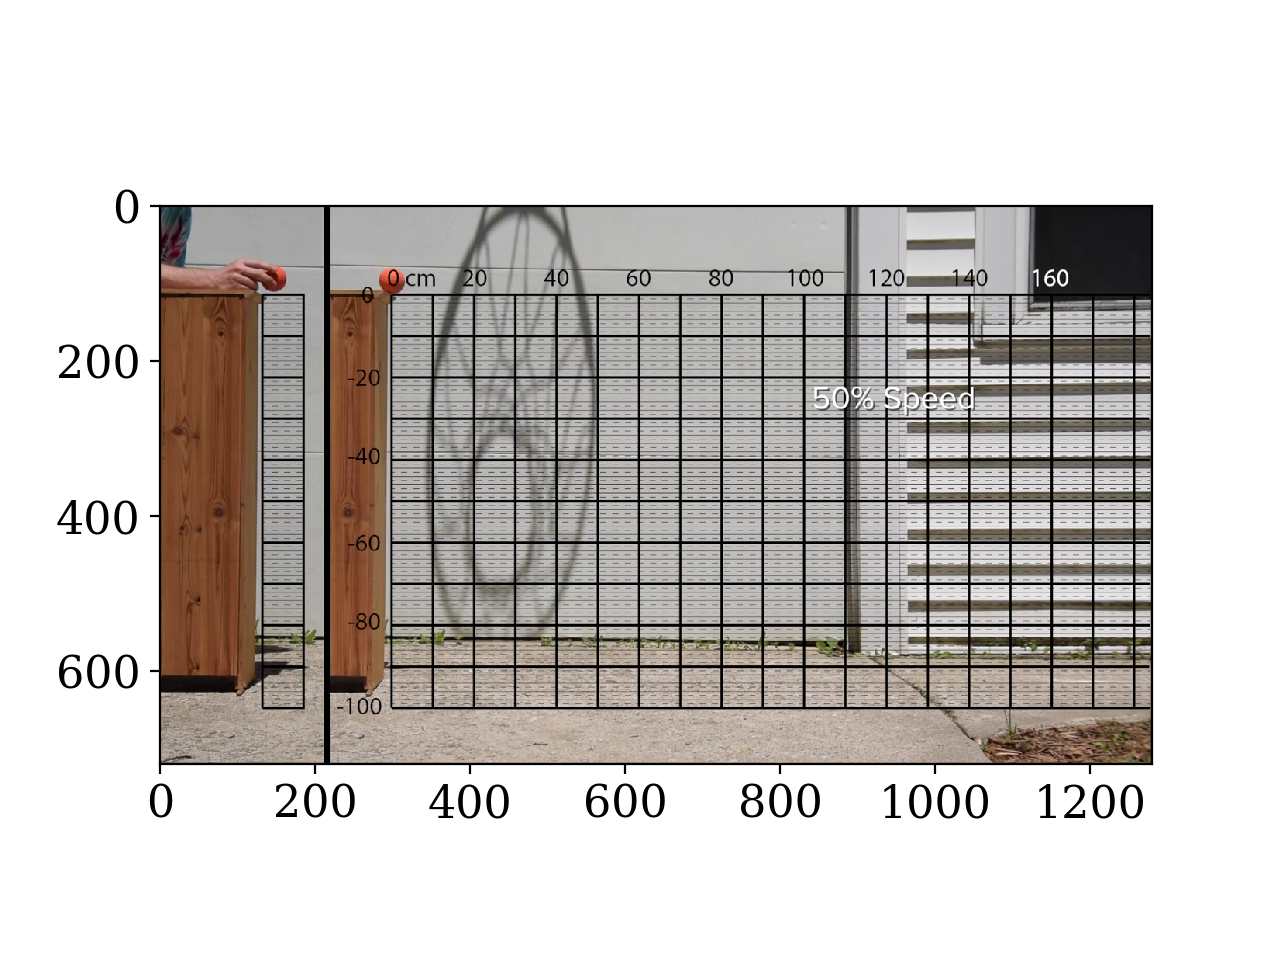

In [30]:
fig = pyplot.figure()
pyplot.imshow(image, interpolation='nearest')

coords2 = []
def onclick(event):
    '''Capture the x,y coordinates of a mouse click on the image'''
    ix, iy = event.xdata, event.ydata
    coords2.append([ix, iy]) 

connectId = fig.canvas.mpl_connect('button_press_event', onclick)


In [31]:
coords2

[[723.33064516129025, 117.98387096774195],
 [723.33064516129025, 169.59677419354841],
 [723.33064516129025, 221.20967741935488],
 [723.33064516129025, 275.40322580645159],
 [723.33064516129025, 332.17741935483866],
 [723.33064516129025, 381.20967741935476],
 [723.33064516129025, 437.98387096774195],
 [723.33064516129025, 489.59677419354836],
 [723.33064516129025, 543.79032258064512]]

In [32]:
y_lines2 = numpy.array(coords2)[:,1]
y_lines2

array([ 117.98387097,  169.59677419,  221.20967742,  275.40322581,
        332.17741935,  381.20967742,  437.98387097,  489.59677419,
        543.79032258])

In [33]:
gap_lines2 = y_lines2[1:] - y_lines2[0:-1]
gap_lines2.mean()

53.225806451612897

Above, we repeated the process to compute the vertical distance between the $10\rm{cm}$ marks (averaging over our clicks): the scaling of distances from this video will need multiplying by $0.1$ to get meters, and dividing by `gap_lines2.mean()`.

Now the fun part! Study the code below: we create a `selector` widget of the `BoundedIntText` type, taking the values from 52 to 77, and stepping by 1. We already played around a lot with the video and found this frame range to contain the portion shown at 50% speed. 

We re-use the `onclick()` function, this time appending to a list named `coords2`, and we call it with an event connection from Matplotlib, just like before. But now we add a call to [`widgets.interact()`](http://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html), using a new function named `catchclick()` that reads a new video frame and refreshes the figure with it.

Execute this cell, then click on the ball position, advance a frame, click on the new ball position, and so on, until frame 77. The mouse click positions will be saved in `coords2`.

We found it better to click on the bottom edge of the ball image, rather than attempt to aim at the ball's center.

<IPython.core.display.Javascript object>


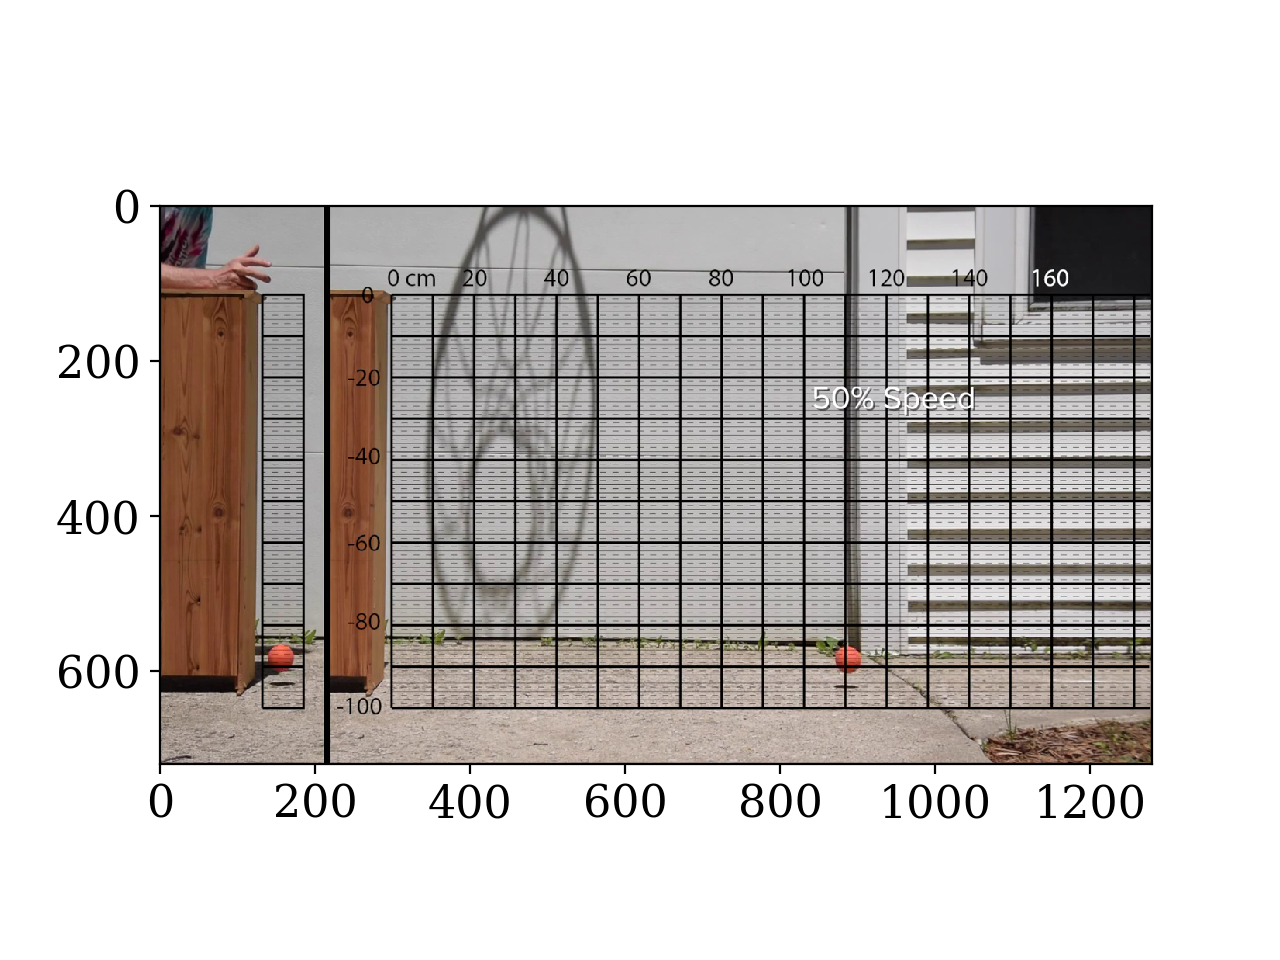

A Jupyter Widget

In [34]:
selector = widgets.BoundedIntText(value=52, min=52, max=77, step=1,
    description='Frame:',
    disabled=False)

coords2 = []
def onclick(event):
    '''Capture the x,y coordinates of a mouse click on the image'''
    ix, iy = event.xdata, event.ydata
    coords2.append([ix, iy]) 


def catchclick(frame):
    image = reader.get_data(frame)
    pyplot.imshow(image, interpolation='nearest');



fig = pyplot.figure()

connectId = fig.canvas.mpl_connect('button_press_event', onclick)

widgets.interact(catchclick, frame=selector);

In [35]:
coords2

[[297.52419354838707, 117.82258064516134],
 [320.74999999999994, 117.82258064516134],
 [343.97580645161287, 120.40322580645159],
 [367.20161290322579, 125.56451612903231],
 [393.00806451612908, 130.72580645161293],
 [416.23387096774189, 138.4677419354839],
 [439.45967741935482, 151.37096774193549],
 [462.68548387096774, 159.11290322580646],
 [485.91129032258067, 172.01612903225805],
 [511.71774193548384, 182.33870967741939],
 [532.36290322580635, 197.82258064516134],
 [558.16935483870975, 218.4677419354839],
 [581.39516129032268, 233.95161290322585],
 [602.04032258064512, 252.01612903225805],
 [625.26612903225805, 272.66129032258061],
 [651.07258064516122, 295.88709677419354],
 [676.8790322580644, 319.11290322580646],
 [697.52419354838707, 344.91935483870964],
 [723.33064516129025, 373.30645161290317],
 [746.55645161290317, 399.11290322580646],
 [767.20161290322585, 430.08064516129025],
 [790.42741935483878, 461.04838709677415],
 [816.23387096774195, 494.59677419354836],
 [839.45967741

Now, convert the positions in pixels to meters, using our scaling for this video, and save the $x$ and $y$ coordinates to new arrays. Below, we plot the ball positions that we captured.

In [36]:
x = numpy.array(coords2)[:,0] *0.1 / gap_lines2.mean()
y = numpy.array(coords2)[:,1] *0.1 / gap_lines2.mean()

<IPython.core.display.Javascript object>


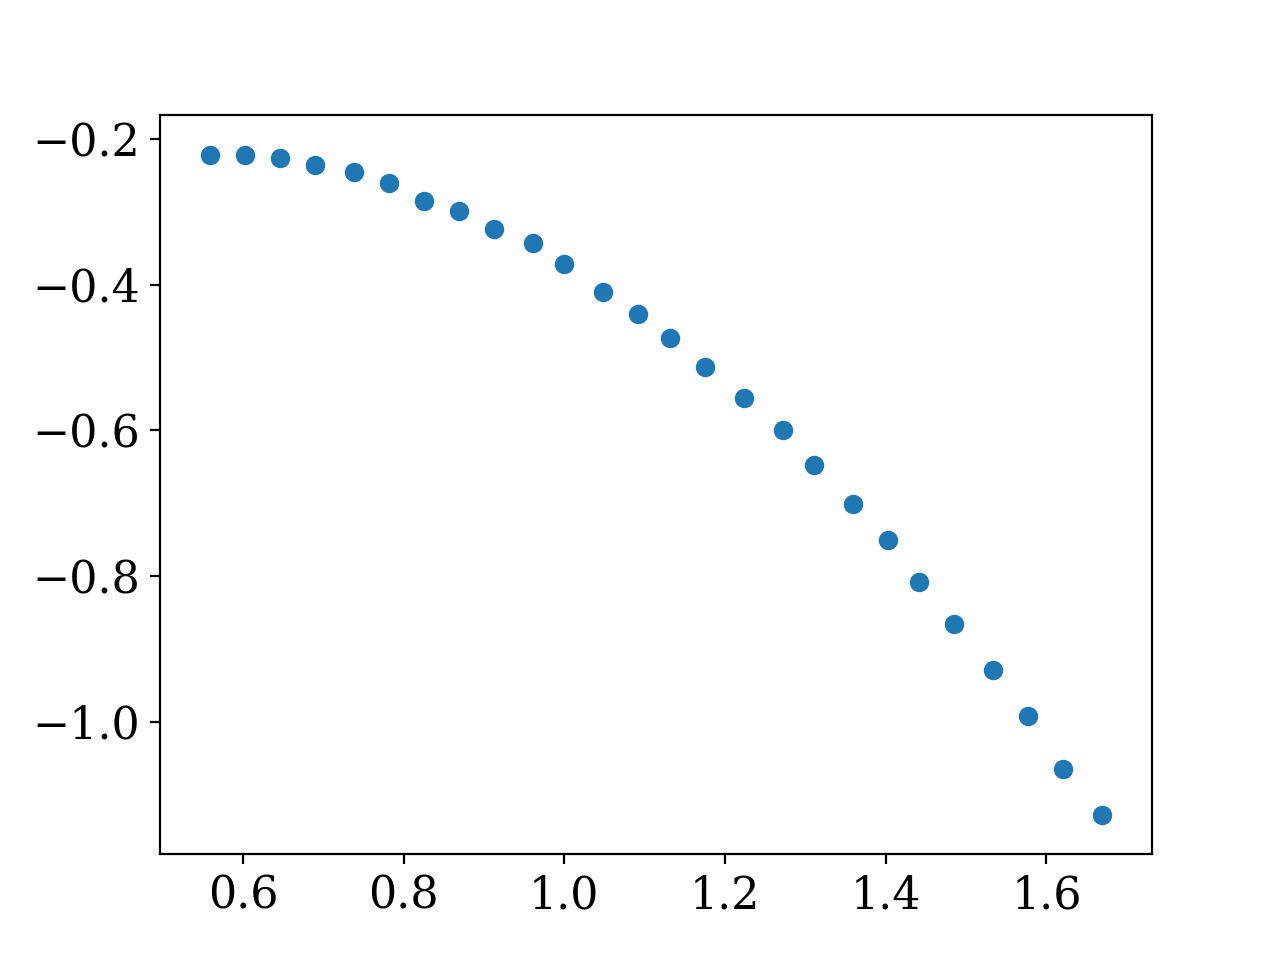

In [37]:
fig = pyplot.figure()
pyplot.scatter(x,-y);

Finally, compute the vertical displacements, then get the vertical velocity and acceleration. And why not repeat the process for the horizontal direction of motion. The time interval is $1/60$ seconds, according to the original video description, i.e., 60 frames per second.

In [38]:
delta_y = (y[1:] - y[:-1])

In [39]:
vy = delta_y * 60
ay = (vy[1:] - vy[:-1]) * 60
print('The acceleration in the y direction is: {:.2f}'.format(ay.mean()))

The acceleration in the y direction is: 9.45


In [40]:
delta_x = (x[1:] - x[:-1])
vx = delta_x * 60
ax = (vx[1:] - vx[:-1]) * 60
print('The acceleration in the x direction is: {:.2f}'.format(ax.mean()))

The acceleration in the x direction is: 0.73


##### Discuss

* What did you get for the $x$ and $y$ accelerations? What did your neighbor get?
* Do the results make sense to you? Why or why not?

## Numerical derivatives

What we did above to compute the average velocity between two captured ball positions is equivalent to a _numerical derivative_. The velocity is the _derivative_ of position with respect to time, and we can approximate its instantaneous value with the average velocity between two close instants in time:

\begin{equation}
v(t) = \frac{dy}{dt} \approx \frac{y(t_i+\Delta t)-y(t_i)}{\Delta t}
\end{equation}

And acceleration is the _derivative_ of velocity with respect to time; we can approximate it with the average acceleration within a time interval:

\begin{equation}
a(t) = \frac{dv}{dt} \approx \frac{v(t_i+\Delta t)-v(t_i)}{\Delta t}
\end{equation}

As you can imagine, the quality of the approximation depends on the size of the time interval: as $\Delta t$ gets smaller, the error also gets smaller.

### Using high-resolution data

Suppose we had some high-resolution experimental data of a falling ball. Might we be able to compute the acceleration of gravity, and get a value closer to the actual acceleration of $9.8\rm{m/s}^2$?

You're in luck! Physics professor Anders Malthe-Sørenssen of Norway has some high-resolution data on the website to accompany his book [3]. We contacted him by email to ask for permission to use the data set of a falling tennis ball, and he graciously agreed. _Thank you!_ His data was recorded with a motion detector on the ball, measuring the $y$ coordinate at tiny time intervals of $\Delta t = 0.001\rm{s}$. Pretty fancy.

We have the data in our repository for this course, but you may have to download it first, if you got this Jupyter notebook by itself. If so, add a code cell below, and execute:

```Python
filename = 'fallingtennisball02.txt'
url = 'http://go.gwu.edu/engcomp3data1'
urlretrieve(url, filename)
```

You already imported `urlretrieve` above to get the video. Remember to then comment the assignment of the `filename` variable below. 

In [41]:
filename = '../../data/fallingtennisball02.txt'
t, y = numpy.loadtxt(filename, usecols=[0,1], unpack=True)

Okay! We should have two new arrays with the time and position data. Let's get a plot of the ball's vertical position.

<IPython.core.display.Javascript object>


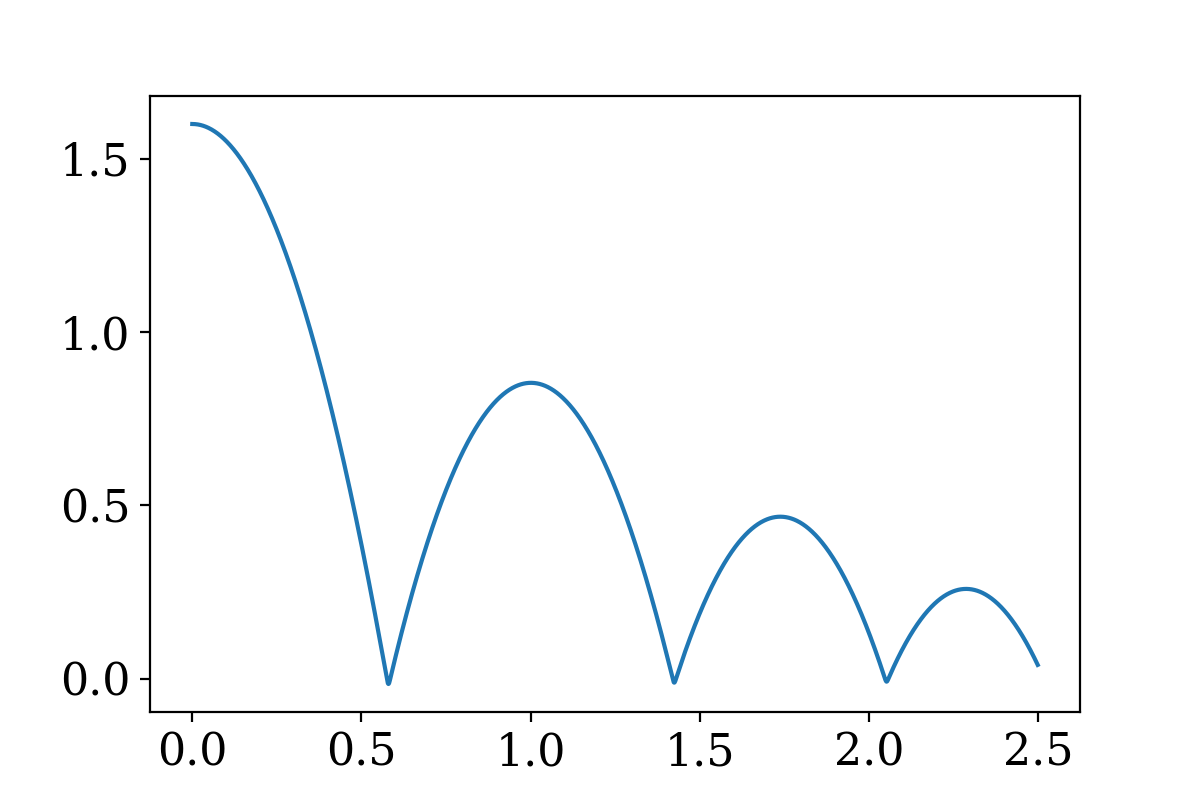

In [42]:
fig = pyplot.figure(figsize=(6,4))
pyplot.plot(t,y);

Neat. The ball bounced 3 times during motion capture. Let's compute the acceleration during the first fall, before the bounce. A quick check on the `y` array shows that there are several points that take a negative value. We can use the first negative entry as the top limit of a slice, and then compute displacements, velocity, and acceleration with that slice.

In [43]:
numpy.where( y < 0 )[0]

array([ 576,  577,  578,  579,  580,  581,  582,  583,  584,  585, 1420,
       1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 2048, 2049,
       2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057])

In [44]:
delta_y = (y[1:576] - y[:575])

In [45]:
dt = t[1]-t[0]
dt

0.001000000000000002

In [46]:
vy = delta_y / dt
ay = (vy[1:] - vy[:-1]) / dt
print('The acceleration in the y direction is: {:.2f}'.format(ay.mean()))

The acceleration in the y direction is: -9.55


Gah. Even with this high-resolution data, we're getting an average value of acceleration that is smaller than the actual acceleration of gravity: $9.8\rm{m/s}^2$. _What is going on?_ Hmm. Let's make a plot of the acceleration values…

<IPython.core.display.Javascript object>


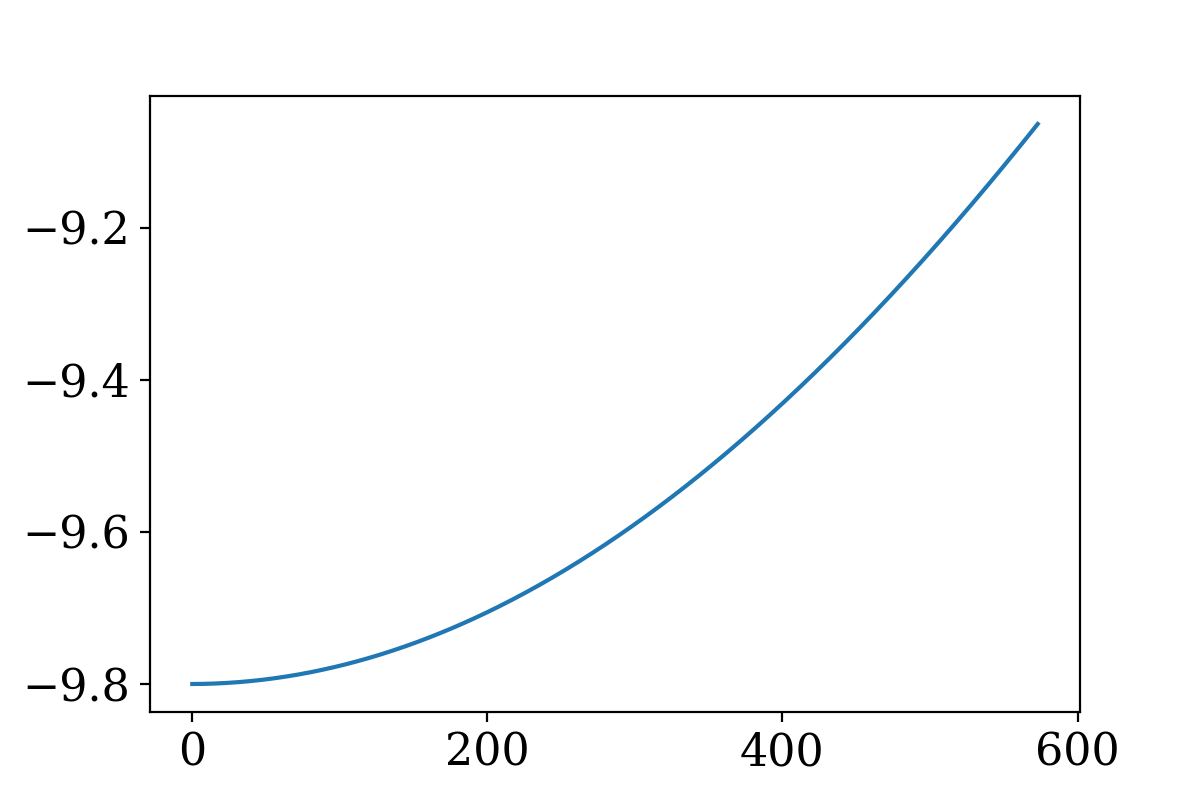

In [47]:
fig = pyplot.figure(figsize=(6,4))
pyplot.plot(ay);

##### Discuss with your neighbor

* What do you see in the plot of acceleration computed from the high-resolution data?
* Can you explain it? What do you think is causing this?

## What we've learned

* Work with images and videos in Python using `imageio`.
* Get interactive figures using the `%matplotlib notebook` command.
* Capture mouse clicks with Matplotlib's `mpl_connect()`.
* Observed acceleration of falling bodies is less than $9.8\rm{m/s}^2$.
* Capture mouse clicks on several video frames using widgets!
* Projectile motion is like falling under gravity, plus a horizontal velocity.
* Compute numerical derivatives using differences via array slicing.
* Real data shows free-fall acceleration decreases in magnitude from $9.8\rm{m/s}^2$.

## References

1.  Strobe of a Falling Ball (2008), MIT Department of Physics Technical Services Group, video under CC-BY-NC, available online on [MIT TechTV](http://techtv.mit.edu/collections/physicsdemos/videos/831-strobe-of-a-falling-ball).

2. The Classic Bullet Projectile Motion Experiment with X & Y Axis Scales (2004), video by [Flipping Physics](http://www.flippingphysics.com/bullet-with-scales.html), Jon Thomas-Palmer. Used with permission.

3. _Elementary Mechanics Using Python_ (2015), Anders Malthe-Sorenssen, Undergraduate Lecture Notes in Physics, Springer. Data at http://folk.uio.no/malthe/mechbook/

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../../style/custom.css'
HTML(open(css_file, "r").read())